In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)

In [2]:
import scipy.io as scio
import pandas as pd

#input
feature1 = r'\Training dataset\ACC_UD.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_UD']
A=AA[:,0:300]

feature2 = r'\Training dataset\ACC_EW.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_EW']
B=BB[:,0:300]

feature3 = r'\Training dataset\ACC_NS.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_NS']
C=CC[:,0:300]

feature4 = r'\Training dataset\VEL_UD.mat'
data4 = scio.loadmat(feature4)
DD=data4['VEL_UD']
D=DD[:,0:300]

feature5 = r'\Training dataset\VEL_EW.mat'
data5 = scio.loadmat(feature5)
EE=data5['VEL_EW']
E=EE[:,0:300]

feature6 = r'\Training dataset\VEL_NS.mat'
data6 = scio.loadmat(feature6)
FF=data6['VEL_NS']
F=FF[:,0:300]

feature7 = r'\Training dataset\DIS_UD.mat'
data7 = scio.loadmat(feature7)
GG=data7['DIS_UD']
G=GG[:,0:300]

feature8 = r'\Training dataset\DIS_EW.mat'
data8 = scio.loadmat(feature8)
HH=data8['DIS_EW']
H=HH[:,0:300]

feature9 = r'\Training dataset\DIS_NS.mat'
data9 = scio.loadmat(feature9)
II=data9['DIS_NS']
I=II[:,0:300]


label = pd.read_csv(open(r'\Training dataset\lable.csv',encoding='UTF-8'))


In [3]:
raw_data1=np.hstack((A,B))
raw_data2=np.hstack((raw_data1,C))
raw_data3=np.hstack((raw_data2,D))
raw_data4=np.hstack((raw_data3,E))
raw_data5=np.hstack((raw_data4,F))
raw_data6=np.hstack((raw_data5,G))
raw_data7=np.hstack((raw_data6,H))
train_xx=np.hstack((raw_data7,I))

print(train_xx.shape)


train_y=label.iloc[:,[1]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
print(train_y[0])
print(train_y.shape)

(45925, 2700)
[1.06980095]
(45925, 1)


In [4]:
train_x=[]
for i in range(len(train_xx)):
    train_x.append(np.array(train_xx[i].reshape(9,1,300)).T)

In [5]:
train_x=np.array(train_x)
#test_x=np.array(test_x)

In [6]:
#3#  ##Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 300, 9))
#test_x = np.reshape(test_x, (test_x.shape[0], 300, 9))
print("0",train_x.shape[0])
print("1",train_x.shape[1])
print(train_x.shape)
#print(train_x)

0 45925
1 300
(45925, 300, 9)


In [7]:
# 定义一个局部注意力层（适用于序列数据）
import tensorflow as tf
from tensorflow.keras import layers

class LocalAttentionLayer(layers.Layer):
    def __init__(self, window_size, units, **kwargs):
        super(LocalAttentionLayer, self).__init__(**kwargs)
        self.window_size = window_size  # 注意力窗口大小（如5, 7）
        self.units = units
        
        # 局部特征提取层：一维卷积替代全连接，限制感受野为窗口大小
        self.conv1 = layers.Conv1D(
            filters=units, 
            kernel_size=window_size, 
            padding='same',  # 保持序列长度不变
            activation='tanh'
        )
        
        # 注意力权重生成层：卷积核为1，输出单通道注意力得分
        self.conv2 = layers.Conv1D(
            filters=1, 
            kernel_size=1,  # 仅融合通道信息，不改变空间范围
            activation='softmax'  # 窗口内归一化
        )
        
        self.mul = layers.Multiply()

    def call(self, inputs, mask=None):
        # 输入形状: [batch_size, seq_len, features]
        
        # Step 1: 通过卷积提取局部特征（窗口内信息）
        # 输出形状: [batch_size, seq_len, units]
        local_features = self.conv1(inputs)  # 卷积核覆盖窗口大小区域
        
        # Step 2: 生成局部注意力权重（每个位置仅关注窗口内邻居）
        # 输出形状: [batch_size, seq_len, 1]
        attention_weights = self.conv2(local_features)  # 窗口内权重归一化
        
        # Step 3: 加权求和（仅窗口内特征参与）
        # 输入与注意力权重逐元素相乘后求和
        weighted_sum = self.mul([inputs, attention_weights])
        weighted_sum = tf.reduce_sum(weighted_sum, axis=1)  # 形状: [batch_size, features]
        
        return weighted_sum

    def get_config(self):
        config = super().get_config()
        config.update({
            "window_size": self.window_size,
            "units": self.units
        })
        return config
    


In [8]:
# 定义一个全局注意力层（适用于序列数据）
class GlobalAttentionLayer(Layer):
    def __init__(self,**kwargs):
        super(GlobalAttentionLayer,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.weight = self.add_weight(name="watt", shape=(input_shape[-1], 1), initializer="normal")
        self.bias = self.add_weight(name="batt", shape=(input_shape[1], 1), initializer="zeros")
        super(GlobalAttentionLayer, self).build(input_shape)
 
    def call(self,x):
        att = K.expand_dims(K.softmax(K.squeeze(K.tanh(K.dot(x,self.weight) + self.bias), axis=-1)), axis=-1)
        return K.sum(x*att, axis=1)
 
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[-1])
 
    def get_config(self):
        return super(GlobalAttentionLayer,self).get_config()

In [9]:
def LocalEncoder(x):
    e = Conv1D(256, 3, padding = 'same')(x)
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
    e = Dropout(0.2)(e)
    
    e = Conv1D(256, 3, padding = 'same')(e)
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
    e = Dropout(0.2)(e) 
    
    e = Conv1D(256, 3, padding = 'same')(e)
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
    e = Dropout(0.2)(e)  
     

    e = Bidirectional(GRU(256, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    e = Bidirectional(GRU(256, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    e = Bidirectional(GRU(256, return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(e)
    
    e = LocalAttentionLayer(256)(e)
    
    return e
    
    

In [10]:
def GlobalEncoder(x):
    e = Conv1D(256, 3, padding = 'same')(x) 
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
    e = Dropout(0.2)(e)
    


#    e = Bidirectional(GRU(16, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    e = Bidirectional(GRU(16, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    e = Bidirectional(GRU(16, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(e)
    
    e = GlobalAttentionLayer()(e)
    
    return e

In [11]:
seed=50
#50 17.20 1.32
drop_rate = 0.2
def get_model():

    inp1 = Input(shape=(300, 9), name='input_layer') 

    x1 = LocalEncoder(inp1)
    x2 = GlobalEncoder(inp1)
    
    e = tf.keras.layers.Concatenate()([x1, x2])


#    e = Dense(256, activation='relu')(concat)#relu
    e = Dense(128, activation='relu')(e)#relu
    e = Dense(1)(e)
    o = Activation('linear', name='output_layer')(e)
    

    #model = Model([inp_seq, inp_lap, inp_feat], out)  ,inpt2
    rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model = Model(inp1, o)
    model.compile(optimizer = rms, loss = 'mean_squared_error')

    return model

In [12]:
model = get_model()
model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 300, 9)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 300, 256)     7168        input_layer[0][0]                
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 300, 256)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 75, 256)      0           re_lu[0][0]                      
_______________________________________________________________________________________

In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor="val_loss",
                               factor=0.1,
                                cooldown= 0,
                                patience= 5,
                                min_lr=0.1e-7)
early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #10  17.20 1.32
callbacks = [lr_reducer, early_stopping_monitor]




model = get_model()
history=model.fit(train_x, train_y, epochs=300, batch_size=256,  
            validation_split=0.1, callbacks=callbacks)  #256 ,train_physics  ,test_physics ,train_physics

pred_train_all = model.predict(train_x).ravel()
#pred_test_all = model.predict(test_x).ravel()  ##ravel() 转换成1列


#pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
#pred_test_all = scaler_seq.inverse_transform(pred_test_all)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/300
162/162 [==============================] - 28s 171ms/step - loss: 0.1344 - val_loss: 0.0546
Epoch 2/300
162/162 [==============================] - 23s 142ms/step - loss: 0.0510 - val_loss: 0.0428
Epoch 3/300
162/162 [==============================] - 23s 141ms/step - loss: 0.0465 - val_loss: 0.0409
Epoch 4/300
162/162 [==============================] - 23s 142ms/step - loss: 0.0441 - val_loss: 0.0363
Epoch 5/300
162/162 [==============================] - 23s 142ms/step - loss: 0.0408 - val_loss: 0.0359
Epoch 6/300
162/162 [==============================] - 23s 142ms/step - loss: 0.0385 - val_loss: 0.0346
Epoch 7/300
162/162 [==============================] - 23s 141ms/step - loss: 0.0370 - val_loss: 0.0305
Epoch 8/300
162/162 [==============================] - 23s 141ms/step - loss: 0.0343 - val_loss: 0.0290
Epoch 9/300
162/162 [==============================] - 23s 141ms/step - loss: 0.0332 - val_loss: 0.0283
Epoch 10/300
162/162 [==============================] - 23s 141m

Text(0, 0.5, 'Loss')

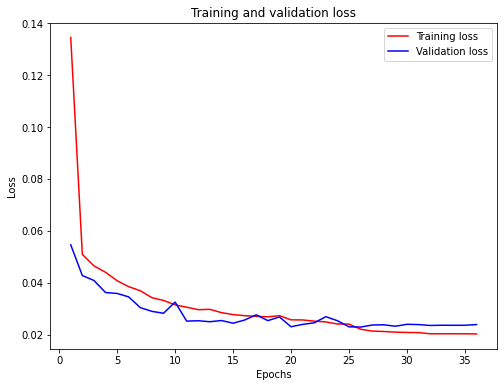

In [14]:
from matplotlib.pyplot import plot,savefig
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(loss)+1)
plt.figure(figsize=(8, 6))

#plt.semilogy(epoch,loss, color="red",label='Training loss')
#plt.semilogy(epoch, val_loss,color="blue", label='Validation loss')

plt.plot(epoch,loss, color="red",label='Training loss')
plt.plot(epoch, val_loss,color="blue", label='Validation loss')


plt.legend()
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [15]:
loss=np.array(loss)
val_loss=np.array(val_loss)
epoch=np.array(epoch)

loss=loss.reshape(loss.shape[0],1)
val_loss=val_loss.reshape(val_loss.shape[0],1)
epoch=epoch.reshape(epoch.shape[0],1)

loss_zong=np.concatenate((epoch,loss,val_loss),axis=1)


print(epoch.shape)
print(val_loss.shape)
print(loss.shape)
print(loss_zong.shape)

data_loss = pd.DataFrame(loss_zong) #将数组转换为dataframe结构
data_loss.columns=['epoch','loss','val_loss']
writer_loss = pd.ExcelWriter(r'\Disloss3.xls')   # 写入Excel文件

data_loss.to_excel(writer_loss,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_loss.save()
writer_loss.close()

(36, 1)
(36, 1)
(36, 1)
(36, 3)


In [16]:
#B = get_model()
#B.load_weights('baseline.hdf5')
#B.summary()

#model.save("Disnet3s.h5", save_format="tf")
#model.save_weights("Magnet3s.h5")

训练标准差STD= 0.13756661896759517
训练误差均值MEAN= -0.0014518779867110684
训练平均绝对误差MAE= 0.10397439666586283
训练RMSE= 0.13757428031381377
训练MAPE= 8.599902220385841
训练r2 score: 0.8476682233604858


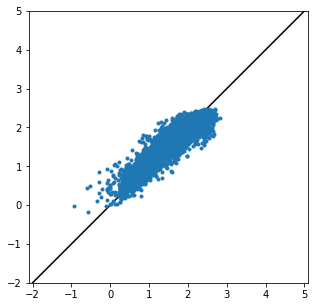

In [17]:
from sklearn import metrics
from sklearn.metrics import r2_score
print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()

In [18]:
#########################保存训练结果####################################
pred_train_all=pred_train_all.reshape(pred_train_all.shape[0],1)

#y_score_tr=y_score_tr.reshape(y_score_tr.shape[0],1)
print(pred_train_all.shape)
print(train_y.shape)

tr_result=np.concatenate((train_y,pred_train_all),axis=1)

print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['Truedis','Predis']
writer_tr = pd.ExcelWriter(r'\Dis\train3.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()
#########################保存训练结果####################################

(45925, 1)
(45925, 1)
(45925, 2)


In [19]:
#震例
import scipy.io as scio
import pandas as pd

#input
feature1z = r'\Test dataset\ACC_UD.mat'
data1z = scio.loadmat(feature1z)
AAz=data1z['ACC_UD']
Az=AAz[:,0:300]

feature2z = r'\Test dataset\ACC_EW.mat'
data2z = scio.loadmat(feature2z)
BBz=data2z['ACC_EW']
Bz=BBz[:,0:300]

feature3z = r'\Test dataset\ACC_NS.mat'
data3z = scio.loadmat(feature3z)
CCz=data3z['ACC_NS']
Cz=CCz[:,0:300]

feature4z = r'\Test dataset\VEL_UD.mat'
data4z = scio.loadmat(feature4z)
DDz=data4z['VEL_UD']
Dz=DDz[:,0:300]

feature5z = r'\Test dataset\VEL_EW.mat'
data5z = scio.loadmat(feature5z)
EEz=data5z['VEL_EW']
Ez=EEz[:,0:300]

feature6z = r'\Test dataset\VEL_NS.mat'
data6z = scio.loadmat(feature6z)
FFz=data6z['VEL_NS']
Fz=FFz[:,0:300]

feature7z = r'\Test dataset\DIS_UD.mat'
data7z = scio.loadmat(feature7z)
GGz=data7z['DIS_UD']
Gz=GGz[:,0:300]

feature8z = r'\Test dataset\DIS_EW.mat'
data8z = scio.loadmat(feature8z)
HHz=data8z['DIS_EW']
Hz=HHz[:,0:300]

feature9z = r'\Test dataset\DIS_NS.mat'
data9z = scio.loadmat(feature9z)
IIz=data9z['DIS_NS']
Iz=IIz[:,0:300]


labelz = pd.read_csv(open(r'\Test dataset\lable.csv',encoding='UTF-8'))


In [20]:
raw_data1z=np.hstack((Az,Bz))
raw_data2z=np.hstack((raw_data1z,Cz))
raw_data3z=np.hstack((raw_data2z,Dz))
raw_data4z=np.hstack((raw_data3z,Ez))
raw_data5z=np.hstack((raw_data4z,Fz))
raw_data6z=np.hstack((raw_data5z,Gz))
raw_data7z=np.hstack((raw_data6z,Hz))
x_dataz=np.hstack((raw_data7z,Iz))

y_dataz=labelz.iloc[:,[1]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
print(y_dataz[0])
print(y_dataz.shape)

[1.79898088]
(10992, 1)


In [21]:
zhenli_y=y_dataz



In [22]:
zhenli_x=[]
for i in range(len(x_dataz)):
    zhenli_x.append(np.array(x_dataz[i].reshape(9,1,300)).T)

In [23]:
zhenli_x=np.array(zhenli_x)

In [24]:
zhenli_x = np.reshape(zhenli_x, (zhenli_x.shape[0], 300, 9))

In [25]:
pred_zhenli_all = model.predict(zhenli_x).ravel()  ##ravel() 转换成1列

震例标准差STD= 0.16217060381883194
震例误差均值MEAN= -0.010148267021667698
震例平均绝对误差MAE= 0.12258702865351281
震例RMSE= 0.16248782128672787
震例MAPE= 10.37666687489747
震例r2 score: 0.8029195692955312


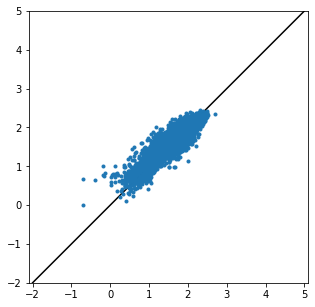

In [26]:
print("震例标准差STD=",np.std(pred_zhenli_all-zhenli_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all-zhenli_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all, zhenli_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all, zhenli_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y.ravel() - pred_zhenli_all) / zhenli_y.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y.ravel(), pred_zhenli_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y.ravel(),pred_zhenli_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()  

In [27]:
#########################保存震例结果####################################
pred_zhenli_all=pred_zhenli_all.reshape(pred_zhenli_all.shape[0],1)

print(pred_zhenli_all.shape)
print(zhenli_y.shape)

tz_result=np.concatenate((zhenli_y,pred_zhenli_all),axis=1)

print(tz_result.shape)

data_tz = pd.DataFrame(tz_result) #将数组转换为dataframe结构
data_tz.columns=['Truedis','Predis']
writer_tz = pd.ExcelWriter(r'\zhenli3.xls')   # 写入Excel文件

data_tz.to_excel(writer_tz,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz.save()
writer_tz.close()
#########################保存震例结果####################################

(10992, 1)
(10992, 1)
(10992, 2)
